Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import os
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

%matplotlib inline

Fetch the data of the tweets for the airline

In [2]:
dataset = pd.read_csv(r'C:\Users\User\PycharmProjects\Sentiment Analysis with LSTM\data\Tweets.csv')
dataset.columns
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
dataset = dataset[['airline_sentiment', 'text']]
dataset.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Visualize the data

<AxesSubplot:ylabel='Frequency'>

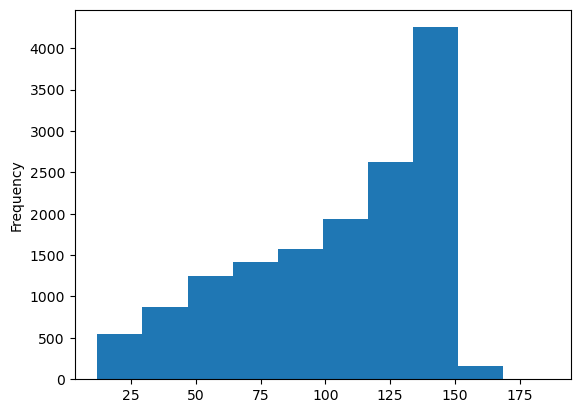

In [4]:
dataset['text'].str.len().plot.hist()

In [5]:
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<AxesSubplot:>

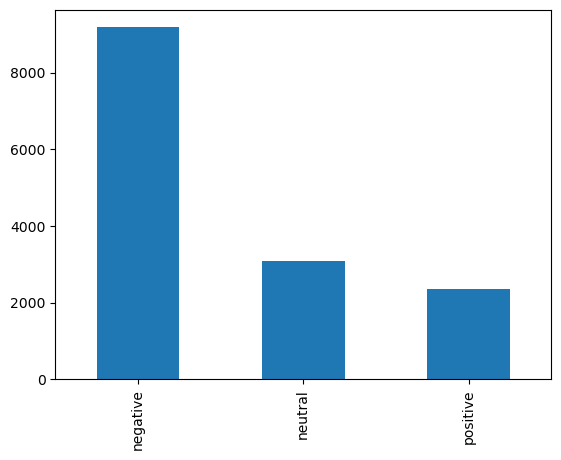

In [6]:
dataset['airline_sentiment'].value_counts().plot.bar()

Data Preprocessing

In [7]:
dataset['text'] = dataset['text'].apply(lambda x: x.lower())
dataset['text'] = dataset['text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', "", x))
dataset['text'].head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercials to ...
2    virginamerica i didnt today must mean i need t...
3    virginamerica its really aggressive to blast o...
4    virginamerica and its a really big bad thing a...
Name: text, dtype: object

All the text need to have same length and represnted as numbers

In [8]:
tokenizer = Tokenizer(num_words = 5000, split = " ")
tokenizer.fit_on_texts(dataset['text'].values)

X = tokenizer.texts_to_sequences(dataset['text'].values)
X = pad_sequences(X)
X[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   78,   57,  218],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   78,  540,  541, 1122, 2455,    1,    2,  197],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   78,
           3,  185,   98,  775,  563,    3,   75,    1,  148,  143,  191],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   78,   64,  132, 3665,    1, 4598,
        4599,  981,   15,   21, 3092, 3666,   61,   54,   22,  487, 2718],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

Create Model

In [9]:
X.shape

(14640, 33)

In [63]:
model = Sequential()
model.add(Embedding(5000, 256, input_length = X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences = True, dropout = 0.3, recurrent_dropout = 0.2))
model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))

In [69]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 256)           1280000   
                                                                 
 dropout_1 (Dropout)         (None, 33, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 33, 256)           525312    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [70]:
y = pd.get_dummies(dataset['airline_sentiment']).values
[print(dataset['airline_sentiment'][i], y[i]) for i in range(0,10)]

neutral [0 1 0]
positive [0 0 1]
neutral [0 1 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
positive [0 0 1]
neutral [0 1 0]
positive [0 0 1]
positive [0 0 1]


[None, None, None, None, None, None, None, None, None, None]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [75]:
batch_size = 32
epochs = 10
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 2)

Epoch 1/10
366/366 - 125s - loss: 0.6392 - accuracy: 0.7351 - 125s/epoch - 341ms/step
Epoch 2/10
366/366 - 115s - loss: 0.4302 - accuracy: 0.8327 - 115s/epoch - 315ms/step
Epoch 3/10
366/366 - 114s - loss: 0.3422 - accuracy: 0.8700 - 114s/epoch - 313ms/step
Epoch 4/10
366/366 - 112s - loss: 0.2825 - accuracy: 0.8973 - 112s/epoch - 307ms/step
Epoch 5/10
366/366 - 117s - loss: 0.2277 - accuracy: 0.9160 - 117s/epoch - 320ms/step
Epoch 6/10
366/366 - 113s - loss: 0.1910 - accuracy: 0.9311 - 113s/epoch - 309ms/step
Epoch 7/10
366/366 - 118s - loss: 0.1583 - accuracy: 0.9435 - 118s/epoch - 321ms/step
Epoch 8/10
366/366 - 113s - loss: 0.1337 - accuracy: 0.9522 - 113s/epoch - 308ms/step
Epoch 9/10
366/366 - 117s - loss: 0.1173 - accuracy: 0.9594 - 117s/epoch - 321ms/step
Epoch 10/10
366/366 - 113s - loss: 0.0938 - accuracy: 0.9682 - 113s/epoch - 308ms/step


In [78]:
prediction = model.predict(X_test)

[print(dataset['text'][i], prediction[i], y_test[i]) for i in range(0, 10)]

92/92 [==============================] - 8s 68ms/step
virginamerica what dhepburn said [9.9982595e-01 1.1955330e-04 5.4621756e-05] [1 0 0]
virginamerica plus youve added commercials to the experience tacky [9.94700015e-01 5.18429279e-03 1.15613235e-04] [1 0 0]
virginamerica i didnt today must mean i need to take another trip [9.9977469e-01 1.7465053e-04 5.0778337e-05] [1 0 0]
virginamerica its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse [0.11215138 0.87929815 0.00855043] [1 0 0]
virginamerica and its a really big bad thing about it [0.01970613 0.01136045 0.9689334 ] [1 0 0]
virginamerica seriously would pay 30 a flight for seats that didnt have this playing
its really the only bad thing about flying va [4.6964156e-04 9.9913681e-01 3.9354080e-04] [0 1 0]
virginamerica yes nearly every time i fly vx this ear worm wont go away  [0.05236205 0.9244108  0.02322705] [1 0 0]
virginamerica really missed a prime opportunity for men withou

[None, None, None, None, None, None, None, None, None, None]

In [79]:
prediction.shape

(2928, 3)

In [84]:
prediction[:10]

array([[9.99825954e-01, 1.19553297e-04, 5.46217561e-05],
       [9.94700015e-01, 5.18429279e-03, 1.15613235e-04],
       [9.99774694e-01, 1.74650530e-04, 5.07783370e-05],
       [1.12151377e-01, 8.79298151e-01, 8.55042599e-03],
       [1.97061263e-02, 1.13604506e-02, 9.68933403e-01],
       [4.69641556e-04, 9.99136806e-01, 3.93540802e-04],
       [5.23620471e-02, 9.24410820e-01, 2.32270509e-02],
       [9.99871731e-01, 1.19456199e-04, 8.82645782e-06],
       [9.99982655e-01, 1.60831733e-05, 1.14196359e-06],
       [9.99911845e-01, 7.54833382e-05, 1.26789373e-05]], dtype=float32)

In [86]:
y_test[:10]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [108]:
type(y)

numpy.ndarray

In [90]:
#(prediction == prediction.max(axis=1, keepdims=1)).astype(int)

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [103]:
predict = np.zeros_like(prediction)
predict[np.arange(len(prediction)), prediction.argmax(1)] = 1
prediction = (predict).astype(int)

In [104]:
prediction[:20]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [113]:
y_test[:10]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)